# Resampling for Model Validation

In [1]:
suppressPackageStartupMessages({
  library(knitr)
  library(readr)
  library(ggplot2)
  library(tidyverse)
  library(car)
  library(caret)
  library(pscl)
  library(boot)

})


### Objective
As public figures from film and television have increasingly  transitioned to political careers in various levels of government. This trend raises questions as to what attributes contribute to an actor's electoral success. Career longevity, accolades, acting credits, and family connections may further enhance an actor's publicity and increase perceived credinility.

This study aims to apply bootstrap and jackknife resampling techniques to identify if career length (in years), number of acting credits, number of awards, and number of immediate family members in politiics are significantly associated with actors becoming elected politicians.Logistic regression modeling will be used to estimate the strength and direction these predictors while assessing model stability under resampling.

In [2]:
actors <- read_csv("https://raw.githubusercontent.com/zkdlyn/APM1210_SA2/refs/heads/main/celebrity_sample30.csv",
show_col_types = FALSE)

head(actors,5)

name,years_active,imdb_credits,family,education,politics,wins
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sam Milby,20,60,0,0,0,0
Daniel Padilla,15,34,1,0,0,1
Nadine Lustre,24,47,0,1,0,5
Bea Alonzo,23,51,0,1,0,0
Alden Richards,14,55,0,1,0,0


In [3]:
summary(actors)

     name            years_active   imdb_credits        family      
 Length:30          Min.   :13.0   Min.   : 15.00   Min.   :0.0000  
 Class :character   1st Qu.:21.5   1st Qu.: 47.50   1st Qu.:0.0000  
 Mode  :character   Median :29.0   Median : 59.50   Median :0.5000  
                    Mean   :30.9   Mean   : 69.00   Mean   :0.8667  
                    3rd Qu.:39.0   3rd Qu.: 85.75   3rd Qu.:1.0000  
                    Max.   :54.0   Max.   :151.00   Max.   :4.0000  
   education        politics        wins      
 Min.   :0.000   Min.   :0.0   Min.   :0.000  
 1st Qu.:1.000   1st Qu.:0.0   1st Qu.:0.000  
 Median :2.000   Median :0.0   Median :0.000  
 Mean   :1.733   Mean   :0.4   Mean   :1.433  
 3rd Qu.:2.000   3rd Qu.:1.0   3rd Qu.:2.000  
 Max.   :3.000   Max.   :1.0   Max.   :9.000  

**Initial Logistic Regression Model**

$$
ln \frac{p}{1-p}= \beta_0 + \beta_1 \cdot (\text{years\_active}) + \beta_2 \cdot (\text{imdb\_credits}) + \beta_3 \cdot (\text{family}) + \beta_4 \cdot (\text{wins})

$$

This formula models the log-odds of an actor becoming an elected politician as a linear combination of four predictors:  years_active, imdb_credits, family and wins.

In [4]:
logit <- glm(politics~ years_active + imdb_credits + family+wins, 
             data = actors, family = binomial)

summary(logit)


Call:
glm(formula = politics ~ years_active + imdb_credits + family + 
    wins, family = binomial, data = actors)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -2.46436    1.78997  -1.377   0.1686  
years_active  0.13991    0.07600   1.841   0.0656 .
imdb_credits -0.03640    0.02422  -1.503   0.1328  
family        1.33552    0.66190   2.018   0.0436 *
wins         -1.03659    0.65870  -1.574   0.1156  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 40.381  on 29  degrees of freedom
Residual deviance: 23.383  on 25  degrees of freedom
AIC: 33.383

Number of Fisher Scoring iterations: 6


             Test stat Pr(>|Test stat|)   
years_active    1.4133         0.234513   
imdb_credits    2.8299         0.092524 . 
family          7.5101         0.006135 **
wins            0.1353         0.712958   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


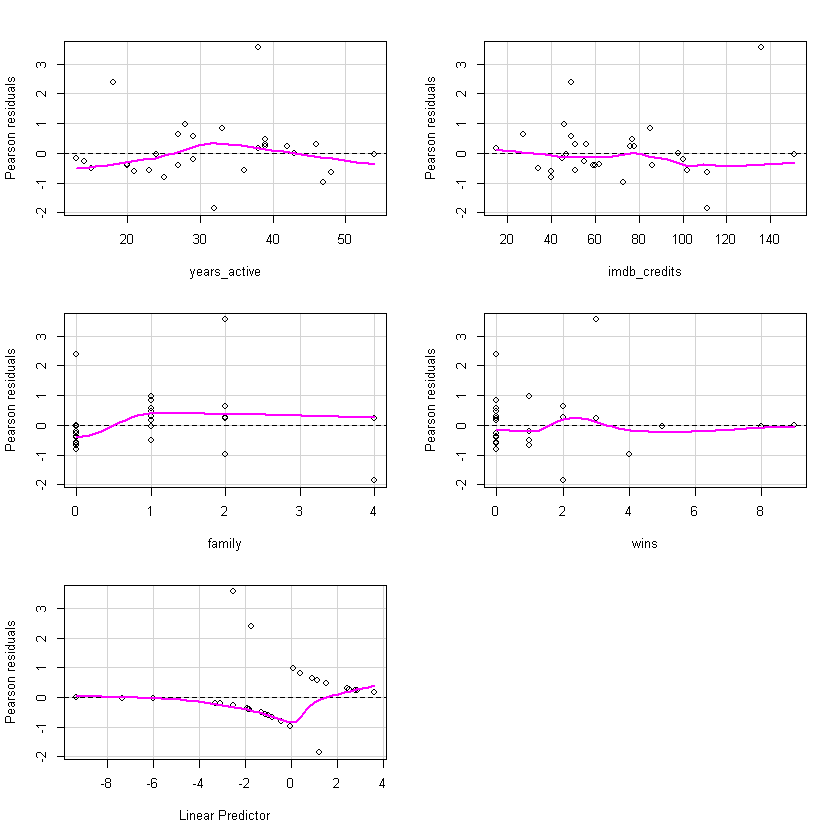

In [5]:
residualPlots(logit)

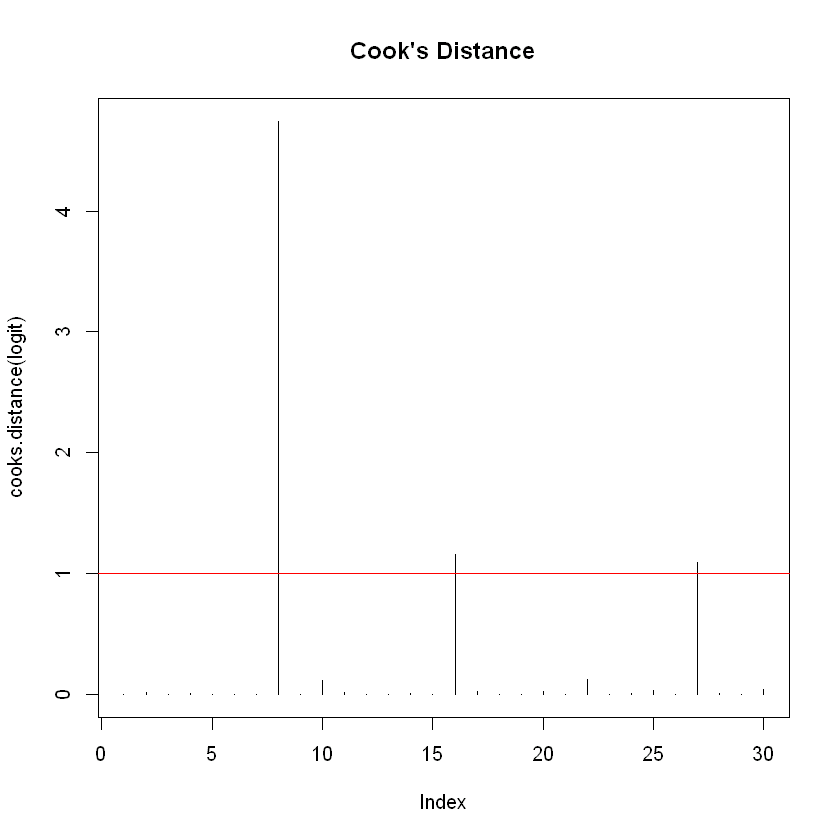

In [6]:
plot(cooks.distance(logit), type = "h", main = "Cook's Distance")
abline(h = 1, col = "red")

In [7]:
car::vif(logit)

years_active imdb_credits       family         wins 
    2.066254     1.591245     1.927919     2.301049

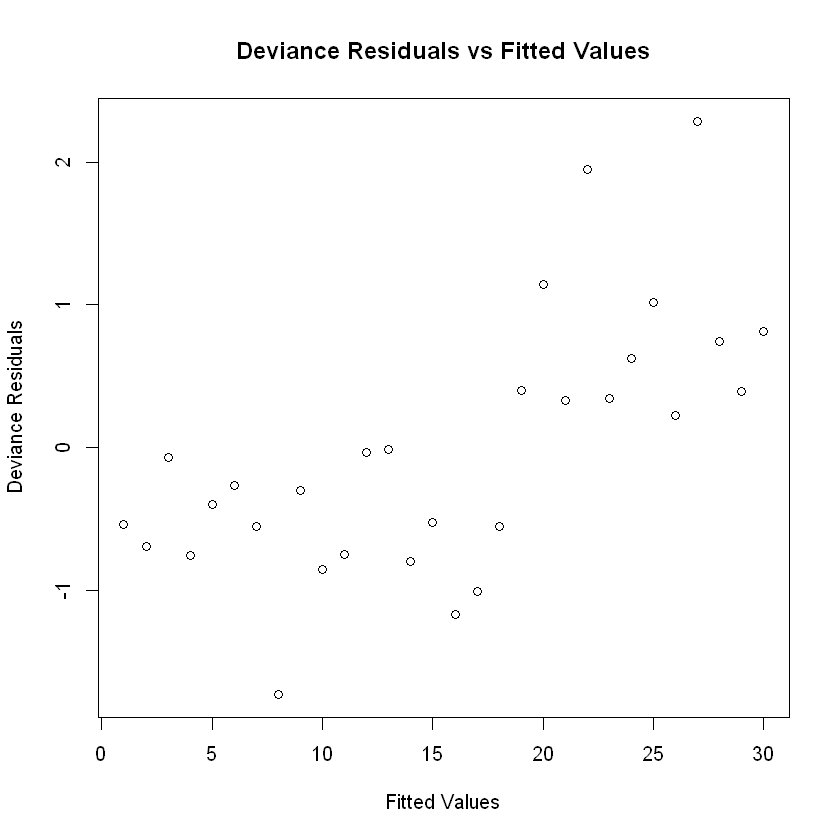

In [8]:
plot(residuals(logit, type="deviance"), 
     main = "Deviance Residuals vs Fitted Values",
     xlab = "Fitted Values", ylab = "Deviance Residuals")

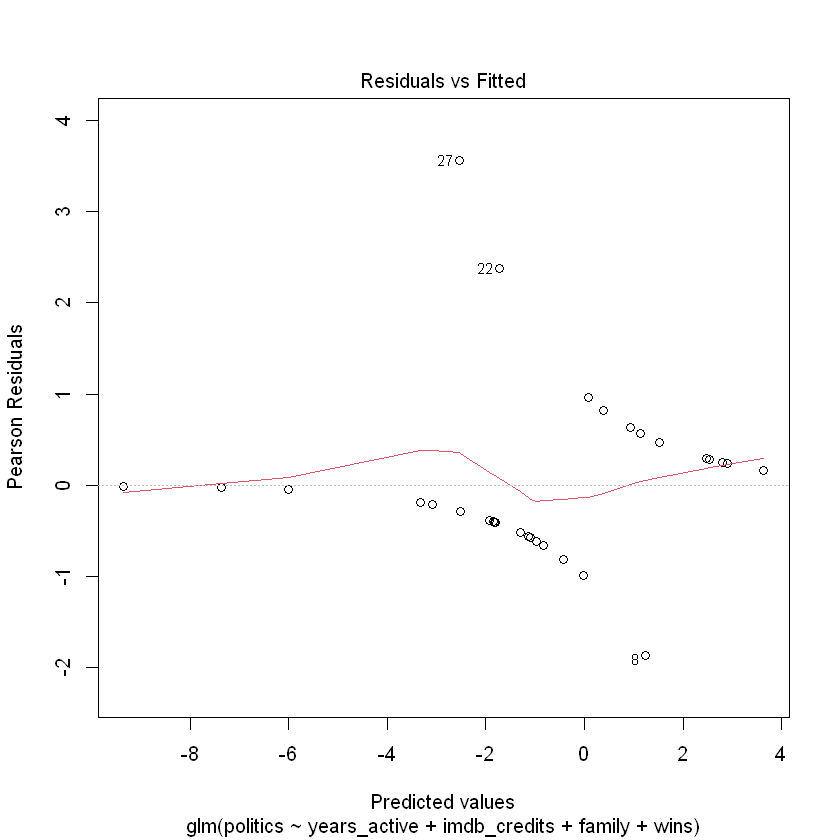

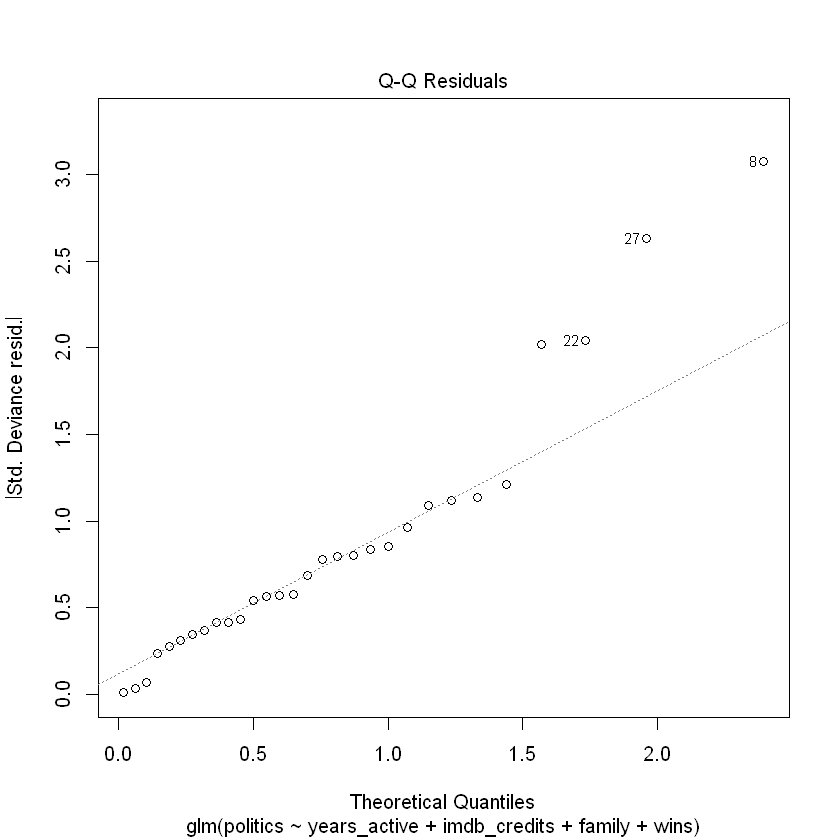

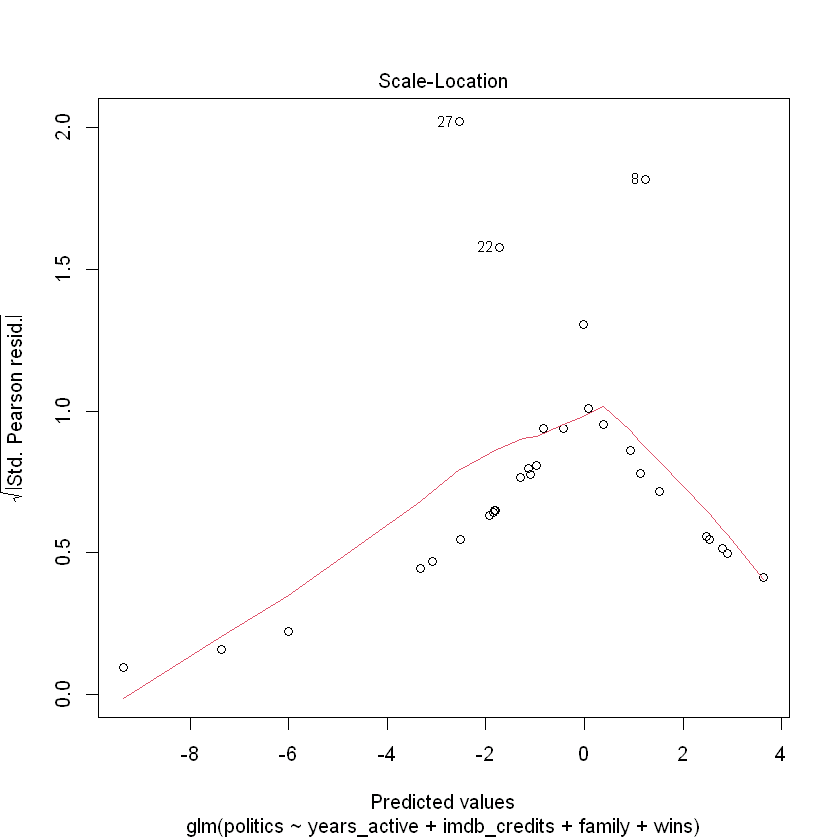

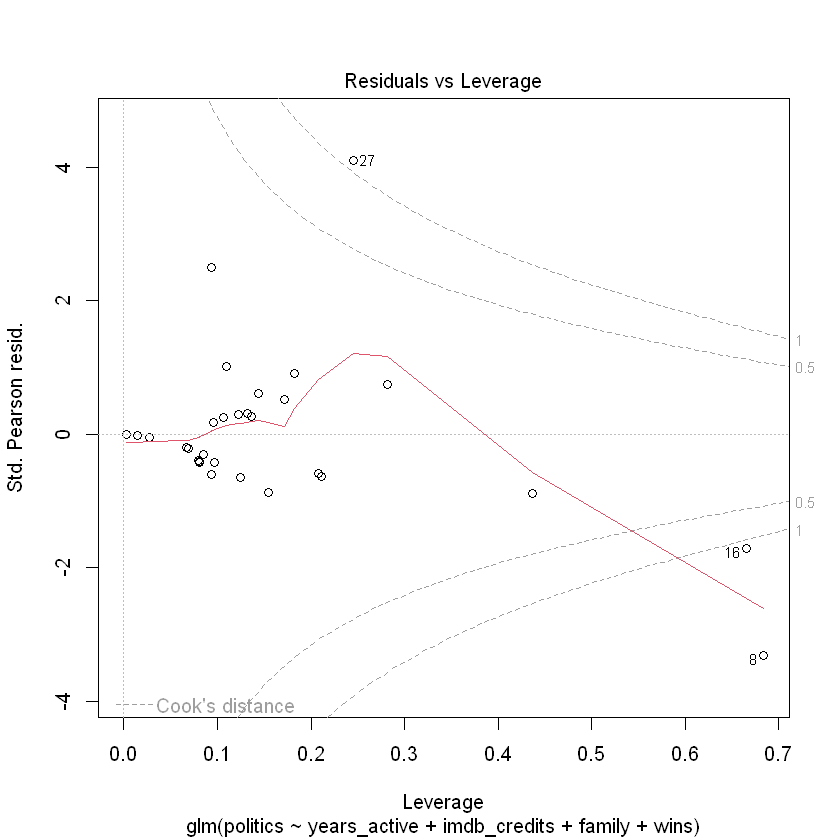

In [18]:
plot(logit)

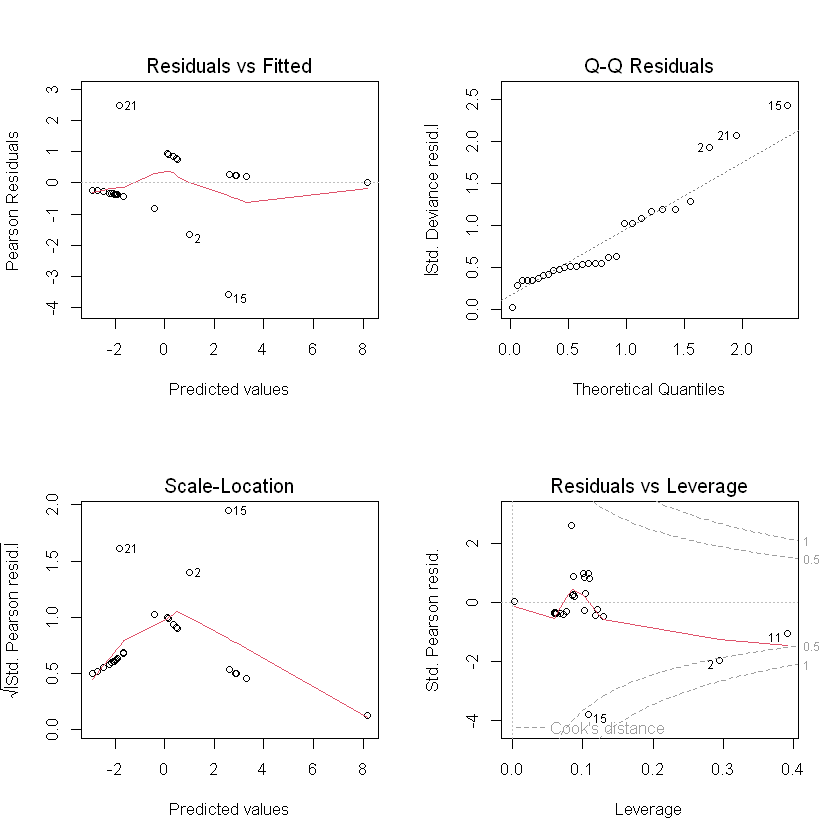

In [40]:
actors_x <- actors[-c(8),]

logit <- glm(politics~ scale(years_active) + family, 
             data = actors_x, family = binomial)
par(mfrow = c(2, 2))
plot(logit)

In [50]:
set.seed(1234)
B<- 100
n <- nrow(actors)
accuracies <- numeric(B)

for (b in 1:B){
  i <- sample(1:n, size=n,replace=TRUE)
  sample.bs <- actors[i, ]

  logit.bs <- suppressWarnings(glm(politics ~ years_active + family, 
                  data = sample.bs, family = binomial))
  
  prob <- predict(logit.bs, newdata = actors, type="response")
  pred <- ifelse(prob > 0.5, 1, 0)
  accuracy <- mean(pred==actors$politics)
  accuracies[b]<- accuracy
}

mean(accuracies)

[1] 0.7303333